In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from multiprocessing import Pool
from functools import partial
import subprocess

def unzip_file(zip_info):
    zip_file_path, extract_path = zip_info
    os.makedirs(extract_path, exist_ok=True)

    # subprocess를 사용하여 unzip 명령어 실행
    subprocess.run(['unzip', '-q', zip_file_path, '-d', extract_path], check=True)
    return f'{zip_file_path} 압축이 {extract_path}에 성공적으로 해제되었습니다.'

# 압축 해제할 경로와 파일 목록
zip_files = [
    ("/content/drive/Shareddrives/Data/dataset.zip", "/tmp"),
]

# 병렬 처리로 압축 해제
if __name__ == '__main__':
    with Pool(processes=len(zip_files)) as pool:  # 파일 개수만큼 프로세스 생성
        results = pool.map(unzip_file, zip_files)

    # 결과 출력
    for result in results:
        print(result)

/content/drive/Shareddrives/Data/dataset.zip 압축이 /tmp에 성공적으로 해제되었습니다.


# 증강함수

In [ ]:
import cv2
import numpy as np
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import os

def augment_with_noise(image):
    """이미지에 랜덤 노이즈 추가"""
    noise = np.random.normal(0, random.uniform(5, 20), image.shape).astype(np.uint8)
    noisy_img = cv2.add(image, noise)
    return noisy_img

def basic_geometric_augment(image):
    """샘플 수 맞추기용 기본 지오메트릭 변환"""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    transforms = [
        # 회전 (최소한의 각도)
        lambda img: cv2.warpAffine(img, cv2.getRotationMatrix2D(center, np.random.uniform(-10, 10), 1.0), (w, h)),
        # 스케일 (작은 변화)
        lambda img: cv2.resize(img, None, fx=np.random.uniform(0.9, 1.1), fy=np.random.uniform(0.9, 1.1)),
        # 밝기 (최소 조정)
        lambda img: cv2.convertScaleAbs(img, alpha=np.random.uniform(0.9, 1.1), beta=np.random.randint(-10, 10))
    ]
    return random.choice(transforms)(image)

def apply_elastic_transform(image, alpha, sigma):
    """안전한 탄성 변환 적용"""
    try:
        # 각 채널별로 처리
        result = np.zeros_like(image)
        random_state = np.random.RandomState(None)

        # 변위 필드 생성 (한 번만)
        shape = image.shape[:2]
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

        # 격자 생성
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

        # 좌표 범위 제한
        dx = np.clip(dx, -shape[0]//4, shape[0]//4)
        dy = np.clip(dy, -shape[1]//4, shape[1]//4)

        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

        # 각 채널에 대해 변환 적용
        for i in range(3):
            result[..., i] = map_coordinates(image[..., i], indices, order=1).reshape(shape)

        # 결과 값 범위 제한
        result = np.clip(result, 0, 255)

        return result.astype(np.uint8)

    except Exception as e:
        print(f"Error in elastic transform: {e}")
        return image  # 오류 발생 시 원본 이미지 반환

def simulate_overlap(image):
    """과일 겹침 시뮬레이션"""
    h, w = image.shape[:2]
    overlay = np.zeros_like(image)

    # 랜덤 위치에 반투명한 원형 영역 생성
    center = (np.random.randint(w//4, 3*w//4), np.random.randint(h//4, 3*h//4))
    radius = np.random.randint(w//6, w//3)

    cv2.circle(overlay, center, radius, (255, 255, 255), -1)
    alpha = np.random.uniform(0.3, 0.7)

    return cv2.addWeighted(image, 1, overlay, alpha, 0)

def apply_partial_occlusion(image):
    """부분 가림 효과 적용"""
    h, w = image.shape[:2]
    mask = np.ones_like(image)

    # 랜덤한 사각형 영역 생성
    x1, y1 = np.random.randint(0, w//2), np.random.randint(0, h//2)
    x2, y2 = x1 + np.random.randint(w//4, w//2), y1 + np.random.randint(h//4, h//2)

    mask[y1:y2, x1:x2] = 0
    return image * mask

def apply_perspective_transform(image):
    """원근 변환 적용"""
    h, w = image.shape[:2]

    # 소스 포인트
    src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])

    # 목표 포인트 (약간의 랜덤 변형)
    dst_points = np.float32([
        [np.random.randint(0, w//8), np.random.randint(0, h//8)],
        [w - np.random.randint(0, w//8), np.random.randint(0, h//8)],
        [w - np.random.randint(0, w//8), h - np.random.randint(0, h//8)],
        [np.random.randint(0, w//8), h - np.random.randint(0, h//8)]
    ])

    # 변환 행렬 계산 및 적용
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    return cv2.warpPerspective(image, matrix, (w, h))


# 전처리 스크립트


Splitting training data into train/val...

Preprocessing and augmenting training data...
Maximum samples per class in train: 60



Preprocessing validation data...



Preprocessing test data...


Processing test data: 100%|██████████| 120/120 [00:00<00:00, 133.44it/s]



Applying final augmentation to training data...


Train - Class banana: 420 images
Train - Class orange: 420 images
Train - Class mixed: 600 images
Train - Class apple: 420 images
Val - Class banana: 15 images
Val - Class orange: 15 images
Val - Class mixed: 4 images
Val - Class apple: 15 images
Test - Class banana: 18 images
Test - Class orange: 18 images
Test - Class mixed: 5 images
Test - Class apple: 19 images

Showing examples for mixed class final augmentation...


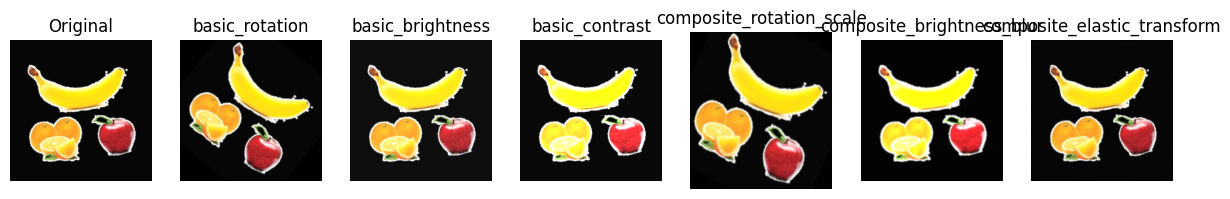

In [ ]:
from scipy.ndimage import gaussian_filter, map_coordinates
import os, cv2, numpy as np
from pathlib import Path
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# 경로 설정
TRAIN_DIR = '/tmp/train_zip/train'
TEST_DIR = '/tmp/test_zip/test'
PREPROCESS_DIR = 'data/preprocess_data'
TARGET_SIZE = 256

random.seed(42)  # 재현성 있는 랜덤

def create_directories():
    if os.path.exists(PREPROCESS_DIR):
        shutil.rmtree(PREPROCESS_DIR)
    os.makedirs(os.path.join(PREPROCESS_DIR, 'train'), exist_ok=True)
    os.makedirs(os.path.join(PREPROCESS_DIR, 'val'), exist_ok=True)  # 검증 데이터용 디렉토리 추가
    os.makedirs(os.path.join(PREPROCESS_DIR, 'test'), exist_ok=True)

def remove_background(image):
    # 기존 코드와 동일
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    masks = [
        cv2.inRange(hsv, np.array([0, 20, 20]), np.array([15, 255, 255])),   # red1
        cv2.inRange(hsv, np.array([165, 20, 20]), np.array([180, 255, 255])),# red2
        cv2.inRange(hsv, np.array([15, 20, 20]), np.array([40, 255, 255])),  # yellow
        cv2.inRange(hsv, np.array([5, 20, 20]), np.array([25, 255, 255]))    # orange
    ]
    color_mask = masks[0]
    for mask in masks[1:]:
        color_mask = cv2.bitwise_or(color_mask, mask)

    edges = cv2.Canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 100, 200)
    final_mask = cv2.bitwise_or(color_mask, edges)

    kernel = np.ones((5, 5), np.uint8)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel)
    final_mask = cv2.dilate(final_mask, kernel, iterations=1)

    return cv2.bitwise_and(image, image, mask=final_mask)


def center_on_black(image):
    # 기존 코드와 동일
    black_bg = np.zeros((TARGET_SIZE, TARGET_SIZE, 3), dtype=np.uint8)
    h, w = image.shape[:2]
    scale = min(TARGET_SIZE / h, TARGET_SIZE / w) * 0.8
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
    y_offset = (TARGET_SIZE - new_h) // 2
    x_offset = (TARGET_SIZE - new_w) // 2
    black_bg[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    return black_bg


def split_train_val_files(input_dir):
    """학습/검증 데이터 분할"""
    class_files = {}
    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg'):
            class_name = filename.split('_')[0]
            if class_name not in class_files:
                class_files[class_name] = []
            class_files[class_name].append(filename)

    train_files = []
    val_files = []

    for class_name, files in class_files.items():
        files.sort()  # 파일 순서 보장
        train_class_files, val_class_files = train_test_split(
            files, test_size=0.2, random_state=42, shuffle=True
        )
        train_files.extend(train_class_files)
        val_files.extend(val_class_files)

    return train_files, val_files

def preprocess_and_select(files, split='train'):
    """데이터 전처리 및 증강"""
    output_dir = os.path.join(PREPROCESS_DIR, split)
    os.makedirs(output_dir, exist_ok=True)

    # 클래스별 파일 분류
    class_files = {}
    for filename in files:
        class_name = filename.split('_')[0]
        if class_name not in class_files:
            class_files[class_name] = []
        class_files[class_name].append(filename)

    # 최대 샘플 수 계산 (학습 데이터의 경우만)
    if split == 'train':
        max_samples = max(len(files) for files in class_files.values())
        print(f"Maximum samples per class in {split}: {max_samples}")

    for class_name, class_files_list in class_files.items():
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        processed_images = []
        # 전처리 진행
        for filename in tqdm(class_files_list, desc=f"Preprocessing {class_name} ({split})", leave=False):
            image_path = os.path.join(TRAIN_DIR, filename)  # 원본 학습 데이터 경로 사용
            image = cv2.imread(image_path)
            if image is None:
                continue
            processed = remove_background(image)
            processed = center_on_black(processed)
            processed_images.append(processed)

        # 학습 데이터이고 샘플 수가 부족한 경우 증강
        if split == 'train':
            current_count = len(processed_images)
            if current_count < max_samples:
                needed = max_samples - current_count
                for _ in range(needed):
                    base_img = random.choice(processed_images)
                    processed_images.append(basic_geometric_augment(base_img))

        # 이미지 저장 (들여쓰기 수정)
        for i, img in enumerate(processed_images):
            save_name = f"{class_name}_{i+1}.jpg"
            cv2.imwrite(os.path.join(class_dir, save_name), img)

def preprocess_test_data():
    """테스트 데이터 전처리"""
    output_dir = os.path.join(PREPROCESS_DIR, 'test')
    os.makedirs(output_dir, exist_ok=True)

    for filename in tqdm(os.listdir(TEST_DIR), desc="Processing test data"):
        if not filename.endswith('.jpg'):
            continue

        class_name = filename.split('_')[0]
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        image_path = os.path.join(TEST_DIR, filename)
        image = cv2.imread(image_path)
        if image is None:
            continue

        processed = remove_background(image)
        processed = center_on_black(processed)
        cv2.imwrite(os.path.join(class_dir, filename), processed)

def final_augment_image(image, class_name=None):
    """최종 증강 기법"""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # 1. 기본 변환 강화
    basic_transforms = {
        'rotation': lambda img: cv2.warpAffine(img, cv2.getRotationMatrix2D(center, np.random.randint(-45, 45), 1.0), (w, h)),
        'brightness': lambda img: cv2.convertScaleAbs(img, alpha=np.random.uniform(0.6, 1.4), beta=np.random.randint(-50, 50)),
        'contrast': lambda img: cv2.convertScaleAbs(img, alpha=np.random.uniform(0.5, 1.5))
    }

    # 2. 복합 변환 개선
    # 2. 복합 변환 개선
    composite_transforms = {
        'rotation_scale': lambda img: cv2.resize(
            cv2.warpAffine(
                img,
                cv2.getRotationMatrix2D(
                    (img.shape[1] // 2, img.shape[0] // 2),  # 중심점
                    np.random.uniform(-45, 45),  # 회전 각도
                    np.random.uniform(0.8, 1.2)  # 스케일
                ),
                (img.shape[1], img.shape[0])  # 출력 크기
            ),
            None,
            fx=np.random.uniform(0.9, 1.1),  # x축 스케일
            fy=np.random.uniform(0.9, 1.1)  # y축 스케일
        ),
        'brightness_blur': lambda img: cv2.GaussianBlur(
            cv2.convertScaleAbs(
                img,
                alpha=np.random.uniform(0.6, 1.4),  # 명암비 조정
                beta=np.random.randint(-30, 30)  # 밝기 오프셋
            ),
            (5, 5),  # 블러 커널 크기
            sigmaX=np.random.uniform(0.5, 1.5)  # 블러 강도
        ),
        'elastic_transform': lambda img: apply_elastic_transform(
            img,
            alpha=np.random.uniform(20, 50),  # 변형 강도
            sigma=np.random.uniform(5, 10)  # 변형 스무딩
        ),

    }

    # 3. Mixed 클래스 특화 변환
    mixed_specific_transforms = {
        'overlap_simulation': lambda img: simulate_overlap(img),
        'partial_occlusion': lambda img: apply_partial_occlusion(img),
        'perspective_transform': lambda img: apply_perspective_transform(img)
    }

    augmented_results = []

    # 기본 변환 적용
    for key in basic_transforms.keys():
        aug_img = basic_transforms[key](image)
        augmented_results.append((f'basic_{key}', aug_img))

    # 복합 변환 적용
    for key in composite_transforms.keys():
        aug_img = composite_transforms[key](image)
        augmented_results.append((f'composite_{key}', aug_img))

    # Mixed 클래스 특화 변환 적용
    if class_name == 'mixed':  # class_name을 파라미터로 받아서 확인
        for key in mixed_specific_transforms.keys():
            aug_img = mixed_specific_transforms[key](image)
            augmented_results.append((f'mixed_{key}', aug_img))

    return augmented_results

def final_augmentation(split='train'):
    """최종 증강 (학습 데이터만)"""
    if split != 'train':
        return

    train_dir = os.path.join(PREPROCESS_DIR, 'train')
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # 원본 이미지만 선택 (class_숫자.jpg 형태)
        images = [f for f in os.listdir(class_path) if f.endswith('.jpg') and len(f.split('_')) == 2]
        images.sort()

        for filename in tqdm(images, desc=f"Final Augmenting {class_name}", leave=False):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue

            aug_imgs = final_augment_image(img, class_name)  # class_name 전달
            base_name = os.path.splitext(filename)[0]

            for (transform_name, aimg) in aug_imgs:
                aug_path = os.path.join(class_path, f"{base_name}_aug_{transform_name}.jpg")
                cv2.imwrite(aug_path, aimg)

def plot_examples_for_mixed():
    class_dir = os.path.join(PREPROCESS_DIR, 'train', 'mixed')
    if not os.path.exists(class_dir):
        print("No mixed class directory found.")
        return
    images = [f for f in os.listdir(class_dir) if f.endswith('.jpg') and '_aug' not in f]
    if not images:
        print("No images found in mixed class.")
        return
    img_path = os.path.join(class_dir, images[0])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aug_imgs = final_augment_image(img)

    plt.figure(figsize=(15, 3))
    plt.subplot(1, len(aug_imgs) + 1, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')

    for i, (name, aimg) in enumerate(aug_imgs, 1):
        plt.subplot(1, len(aug_imgs) + 1, i+1)
        plt.imshow(cv2.cvtColor(aimg, cv2.COLOR_BGR2RGB))
        plt.title(name)  # 증강 기법 이름 표시
        plt.axis('off')
    plt.show()


if __name__ == "__main__":
    create_directories()

    print("\nSplitting training data into train/val...")
    train_files, val_files = split_train_val_files(TRAIN_DIR)

    print("\nPreprocessing and augmenting training data...")
    preprocess_and_select(train_files, split='train')

    print("\nPreprocessing validation data...")
    preprocess_and_select(val_files, split='val')

    print("\nPreprocessing test data...")
    preprocess_test_data()

    print("\nApplying final augmentation to training data...")
    final_augmentation(split='train')

    # 최종 데이터 수 출력
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(PREPROCESS_DIR, split)
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if os.path.isdir(class_path):
                count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
                print(f"{split.capitalize()} - Class {class_name}: {count} images")
    print("\nShowing examples for mixed class final augmentation...")
    plot_examples_for_mixed()

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import pickle
from sklearn.preprocessing import LabelEncoder

# 경로 설정
PREPROCESS_DIR = 'data/preprocess_data'
FEATURE_DIR = 'data/feature_data'
os.makedirs(FEATURE_DIR, exist_ok=True)

class FeatureExtractor:
    def __init__(self, input_size=256):
        self.input_size = input_size
        self.label_encoder = LabelEncoder()

    def extract_color_features(self, img):
        """컬러 관련 특징 추출"""
        # 각 채널별 평균과 표준편차
        means = img.mean(axis=(0, 1))
        stds = img.std(axis=(0, 1))

        # 각 채널별 히스토그램
        features = []
        for i in range(3):  # RGB 각 채널
            hist = cv2.calcHist([img], [i], None, [32], [0, 256])
            hist = hist.flatten() / hist.sum()  # 정규화
            features.extend(hist)

        features.extend(means)
        features.extend(stds)
        return np.array(features)

    def extract_texture_features(self, img):
        """텍스처 특징 추출"""
        # 그레이스케일 변환
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Sobel 엣지 검출
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        # 엣지 강도와 방향
        magnitude = np.sqrt(sobelx**2 + sobely**2)
        direction = np.arctan2(sobely, sobelx)

        # 통계적 특징
        features = [
            np.mean(magnitude),  # 평균 엣지 강도
            np.std(magnitude),   # 엣지 강도의 표준편차
            np.percentile(magnitude, 90),  # 90번째 퍼센타일
            np.mean(direction),  # 평균 엣지 방향
            np.std(direction),   # 엣지 방향의 표준편차
        ]

        # LBP와 유사한 local 패턴 분석
        kernel_size = 3
        local_mean = cv2.blur(gray, (kernel_size, kernel_size))
        pattern = (gray > local_mean).astype(np.uint8)
        pattern_hist = cv2.calcHist([pattern], [0], None, [2], [0, 2])
        pattern_hist = pattern_hist.flatten() / pattern_hist.sum()

        features.extend(pattern_hist)
        return np.array(features)

    def extract_shape_features(self, img):
        """형태 관련 특징 추출"""
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # 이진화 (이미 엣지 정보가 포함된 이미지이므로)
        _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

        # 컨투어 찾기
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            return np.zeros(5)

        # 가장 큰 컨투어 선택
        largest_contour = max(contours, key=cv2.contourArea)

        # 특징 추출
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        hull = cv2.convexHull(largest_contour)
        hull_area = cv2.contourArea(hull)

        features = [
            area / (self.input_size ** 2),  # 정규화된 면적
            perimeter / (4 * self.input_size),  # 정규화된 둘레
            hull_area / (self.input_size ** 2),  # 정규화된 컨벡스 헐 면적
            4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0,  # 원형도
            area / hull_area if hull_area > 0 else 0  # 볼록도
        ]

        return np.array(features)

    def process_dataset(self, split='train'):
        """데이터셋 처리 및 특징 추출"""
        data_dir = os.path.join(PREPROCESS_DIR, split)
        features_list = []
        labels = []
        image_paths = []

        for class_name in os.listdir(data_dir):
            class_dir = os.path.join(data_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            print(f"Processing {split} - {class_name}")
            for img_name in tqdm(os.listdir(class_dir)):
                if not img_name.endswith('.jpg'):
                    continue

                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # 특징 추출
                color_features = self.extract_color_features(img)
                texture_features = self.extract_texture_features(img)
                shape_features = self.extract_shape_features(img)

                # 모든 특징 합치기
                all_features = np.concatenate([
                    color_features,
                    texture_features,
                    shape_features
                ])

                features_list.append(all_features)
                labels.append(class_name)
                image_paths.append(img_path)

        # 특징을 numpy 배열로 변환
        X = np.array(features_list)

        # 레이블 인코딩 (train일 때만 fit)
        if split == 'train':
            y = self.label_encoder.fit_transform(labels)
        else:
            y = self.label_encoder.transform(labels)

        return X, y, image_paths

    def prepare_data(self):
        """전체 데이터셋 준비"""
        # 이미 분할된 데이터셋 처리
        print("Processing training data...")
        X_train, y_train, train_paths = self.process_dataset('train')

        print("Processing validation data...")
        X_val, y_val, val_paths = self.process_dataset('val')

        print("Processing test data...")
        X_test, y_test, test_paths = self.process_dataset('test')

        # 데이터 저장
        data = {
            'X_train': X_train,
            'X_val': X_val,
            'X_test': X_test,
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test,
            'train_paths': train_paths,
            'val_paths': val_paths,
            'test_paths': test_paths,
            'label_encoder': self.label_encoder
        }

        with open(os.path.join(FEATURE_DIR, 'multimodal_data.pkl'), 'wb') as f:
            pickle.dump(data, f)

        print("\nFeature shapes:")
        print(f"X_train: {X_train.shape}")
        print(f"X_val: {X_val.shape}")
        print(f"X_test: {X_test.shape}")

        print("\nSample counts:")
        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Test samples: {len(X_test)}")

        return data

# 특징 추출 실행
if __name__ == "__main__":
    extractor = FeatureExtractor()
    data = extractor.prepare_data()
    print("\nFeature extraction completed and saved!")

Processing training data...
Processing train - banana


100%|██████████| 420/420 [00:03<00:00, 113.16it/s]


Processing train - orange


100%|██████████| 420/420 [00:03<00:00, 111.10it/s]


Processing train - mixed


100%|██████████| 600/600 [00:05<00:00, 111.11it/s]


Processing train - apple


100%|██████████| 420/420 [00:03<00:00, 111.45it/s]


Processing validation data...
Processing val - banana


100%|██████████| 15/15 [00:00<00:00, 112.14it/s]


Processing val - orange


100%|██████████| 15/15 [00:00<00:00, 108.79it/s]


Processing val - mixed


100%|██████████| 4/4 [00:00<00:00, 108.67it/s]


Processing val - apple


100%|██████████| 15/15 [00:00<00:00, 110.02it/s]


Processing test data...
Processing test - banana


100%|██████████| 18/18 [00:00<00:00, 81.75it/s]


Processing test - orange


100%|██████████| 18/18 [00:00<00:00, 109.57it/s]


Processing test - mixed


100%|██████████| 5/5 [00:00<00:00, 111.38it/s]


Processing test - apple


100%|██████████| 19/19 [00:00<00:00, 111.01it/s]


Feature shapes:
X_train: (1860, 114)
X_val: (49, 114)
X_test: (60, 114)

Sample counts:
Training samples: 1860
Validation samples: 49
Test samples: 60

Feature extraction completed and saved!


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  8.32it/s]


Train Loss: 0.2032, Train Acc: 0.9570
Val Loss: 0.0625, Val Acc: 1.0000, Val F1: 1.0000

Epoch 2/5


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Train Loss: 0.0082, Train Acc: 1.0000
Val Loss: 0.0456, Val Acc: 1.0000, Val F1: 1.0000

Epoch 3/5


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  8.11it/s]


Train Loss: 0.0036, Train Acc: 1.0000
Val Loss: 0.0387, Val Acc: 1.0000, Val F1: 1.0000

Epoch 4/5


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


Train Loss: 0.0025, Train Acc: 1.0000
Val Loss: 0.0364, Val Acc: 1.0000, Val F1: 1.0000

Epoch 5/5


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]


Train Loss: 0.0022, Train Acc: 1.0000
Val Loss: 0.0357, Val Acc: 1.0000, Val F1: 1.0000


<ipython-input-7-d803d26ca855>:341: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')
Testing: 100%|██████████| 4/4 [00:00<00:00,  7.38

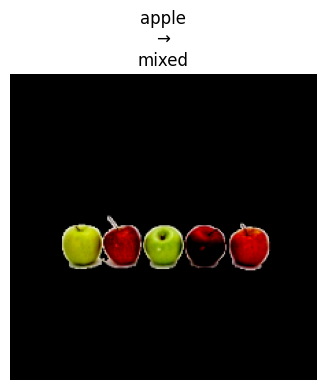


Test Results:
Test Loss: 0.0552
Test Accuracy: 0.9833
Test F1 Score: 0.9839

Test Classification Report:
              precision    recall  f1-score   support

       apple       1.00      0.95      0.97        19
      banana       1.00      1.00      1.00        18
       mixed       0.83      1.00      0.91         5
      orange       1.00      1.00      1.00        18

    accuracy                           0.98        60
   macro avg       0.96      0.99      0.97        60
weighted avg       0.99      0.98      0.98        60



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import random

# 기본 설정
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "google/vit-base-patch16-224"
PREPROCESS_DIR = 'data/preprocess_data'
PATIENCE = 5  # Early stopping patience
SEED = 42  # 재현성을 위한 시드 설정

def seed_everything(seed):
    """재현성을 위한 시드 고정 함수"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, feature_extractor, split='train'):
        self.root_dir = os.path.join(root_dir, split)
        self.feature_extractor = feature_extractor
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # 클래스 및 이미지 경로 수집
        for idx, class_name in enumerate(sorted(os.listdir(self.root_dir))):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in sorted(os.listdir(class_dir)):  # 파일 순서 정렬
                    if img_name.endswith('.jpg'):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # ViT feature extractor 적용
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = inputs.pixel_values.squeeze()

        label = self.labels[idx]
        return pixel_values, label

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc='Training')
    for pixel_values, labels in progress_bar:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values).logits
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """혼동 행렬 시각화"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()

class EarlyStopping:
    """Early stopping 구현"""
    def __init__(self, patience=7, min_delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, optimizer, epoch, val_acc):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer, epoch, val_acc)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer, epoch, val_acc)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch, val_acc):
        """모델 체크포인트 저장"""
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }, self.path)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for pixel_values, labels in tqdm(val_loader, desc='Evaluating'):
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=pixel_values).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_loss = total_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, val_acc, val_f1, all_preds, all_labels

def plot_misclassified_images(images, true_labels, pred_labels, class_names, num_images=10):
    """오분류된 이미지 시각화"""
    n = min(len(images), num_images)
    if n == 0:
        print("No misclassified images found.")
        return

    fig = plt.figure(figsize=(20, 4))
    for idx in range(n):
        ax = plt.subplot(1, n, idx + 1)
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'{class_names[true_labels[idx]]}\n→\n{class_names[pred_labels[idx]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('misclassified_examples.png')
    plt.show()

def test(model, test_loader, criterion, device, idx_to_class):
    """테스트 데이터에 대한 최종 평가"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    misclassified_images = []
    misclassified_true = []
    misclassified_pred = []

    with torch.no_grad():
        for pixel_values, labels in tqdm(test_loader, desc='Testing'):
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=pixel_values).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)

            # 오분류된 이미지 수집
            misclassified_mask = preds != labels
            if misclassified_mask.any():
                misclassified_images.extend(pixel_values[misclassified_mask])
                misclassified_true.extend(labels[misclassified_mask].cpu().numpy())
                misclassified_pred.extend(preds[misclassified_mask].cpu().numpy())

            preds = preds.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader)
    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    # 분류 리포트 생성
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
    report = classification_report(all_labels, all_preds, target_names=class_names)

    # 혼동 행렬 생성 및 시각화
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names, title='Test Confusion Matrix')

    # 오분류된 이미지 시각화
    plot_misclassified_images(
        misclassified_images,
        misclassified_true,
        misclassified_pred,
        class_names
    )

    return test_loss, test_acc, test_f1, report

def main():
    # 시드 고정
    seed_everything(SEED)
    print(f"Using device: {DEVICE}")

    # Feature extractor 및 모델 로드
    feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)
    model = ViTForImageClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(os.listdir(os.path.join(PREPROCESS_DIR, 'train'))),
        ignore_mismatched_sizes=True
    )
    model = model.to(DEVICE)

    # 데이터셋 및 데이터로더 생성
    train_dataset = CustomImageDataset(PREPROCESS_DIR, feature_extractor, split='train')
    val_dataset = CustomImageDataset(PREPROCESS_DIR, feature_extractor, split='val')
    test_dataset = CustomImageDataset(PREPROCESS_DIR, feature_extractor, split='test')

    # Worker 초기화 함수 정의
    def worker_init_fn(worker_id):
        worker_seed = SEED + worker_id
        random.seed(worker_seed)
        np.random.seed(worker_seed)
        torch.manual_seed(worker_seed)

    # DataLoader 생성 시 worker_init_fn 및 generator 설정
    generator = torch.Generator()
    generator.manual_seed(SEED)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        worker_init_fn=worker_init_fn,
        generator=generator
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        worker_init_fn=worker_init_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        worker_init_fn=worker_init_fn
    )

    # Loss function과 optimizer 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    # Early stopping 초기화
    early_stopping = EarlyStopping(patience=PATIENCE, path='best_model.pth')

    # 클래스 이름 매핑
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

    # 학습 루프
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # 학습
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)

        # 검증
        val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(model, val_loader, criterion, DEVICE)

        # 스케줄러 스텝
        scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Early stopping 체크
        early_stopping(val_loss, model, optimizer, epoch, val_acc)

        # 현재 에폭의 혼동 행렬 생성 및 저장
        class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
        cm = confusion_matrix(val_labels, val_preds)
        plot_confusion_matrix(cm, class_names, title=f'Validation Confusion Matrix Epoch {epoch+1}')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 최고 성능 모델 로드
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # 테스트 데이터로 최종 평가
    test_loss, test_acc, test_f1, test_report = test(model, test_loader, criterion, DEVICE, idx_to_class)
    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("\nTest Classification Report:")
    print(test_report)

if __name__ == "__main__":
    main()

Using device: cuda


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]


Epoch 1/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 10.81it/s]


Train Loss: 0.8688, Train Acc: 0.8898
Val Loss: 1.3148, Val Acc: 0.8367, Val F1: 0.8537
Current LR: 0.001000

Epoch 2/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.59it/s]


Train Loss: 0.2309, Train Acc: 0.9715
Val Loss: 1.0367, Val Acc: 0.9184, Val F1: 0.9176
Current LR: 0.001000

Epoch 3/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.28it/s]


Train Loss: 0.2356, Train Acc: 0.9677
Val Loss: 0.2613, Val Acc: 0.9592, Val F1: 0.9530
Current LR: 0.001000

Epoch 4/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]


Train Loss: 0.0861, Train Acc: 0.9860
Val Loss: 0.5266, Val Acc: 0.9388, Val F1: 0.9214
Current LR: 0.001000
EarlyStopping counter: 1 out of 5

Epoch 5/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.11it/s]


Train Loss: 0.2148, Train Acc: 0.9769
Val Loss: 0.5507, Val Acc: 0.9184, Val F1: 0.9210
Current LR: 0.001000
EarlyStopping counter: 2 out of 5

Epoch 6/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.66it/s]


Train Loss: 0.1230, Train Acc: 0.9817
Val Loss: 0.5940, Val Acc: 0.9592, Val F1: 0.9592
Current LR: 0.001000
EarlyStopping counter: 3 out of 5

Epoch 7/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.51it/s]


Train Loss: 0.1988, Train Acc: 0.9753
Val Loss: 0.6852, Val Acc: 0.9388, Val F1: 0.9382
Current LR: 0.000100
EarlyStopping counter: 4 out of 5

Epoch 8/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.34it/s]


Train Loss: 0.0817, Train Acc: 0.9941
Val Loss: 0.6752, Val Acc: 0.9388, Val F1: 0.9382
Current LR: 0.000100
EarlyStopping counter: 5 out of 5


<ipython-input-8-c52ae21f8962>:274: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Early stopping triggered


Testing: 100%|██████████| 4/4 [00:00<00:00, 11.08it/s]


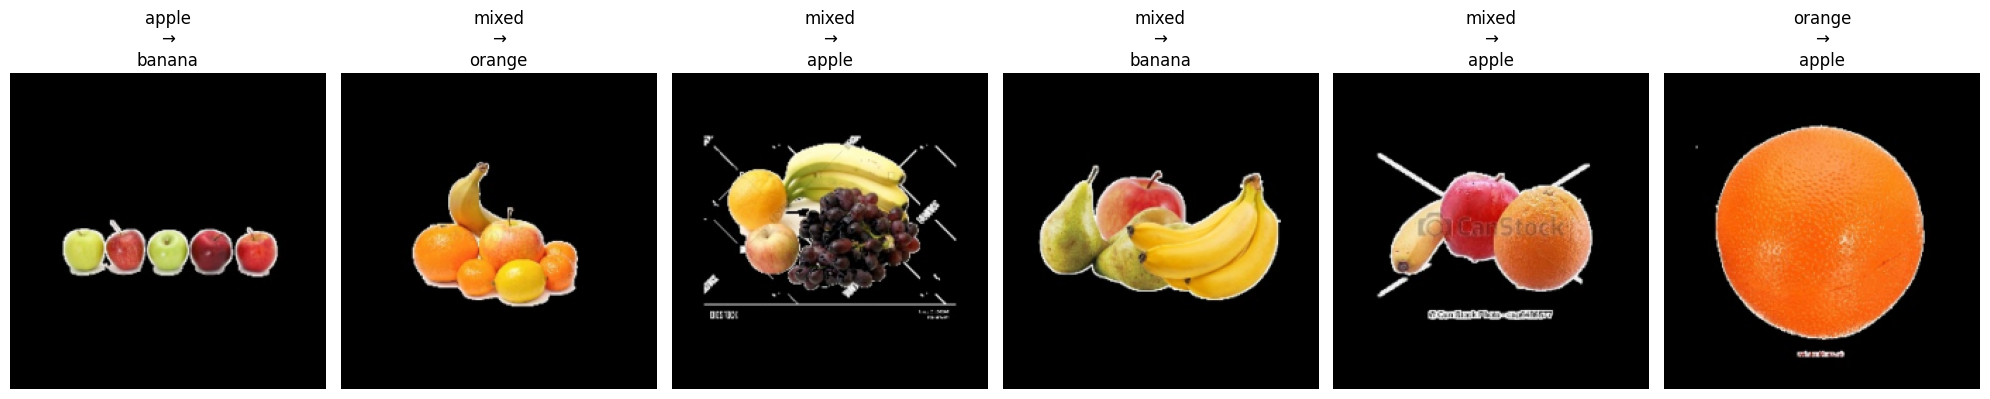


Test Results:
Test Loss: 1.0485
Test Accuracy: 0.9000
Test F1 Score: 0.8803

Test Classification Report:
              precision    recall  f1-score   support

       apple       0.86      0.95      0.90        19
      banana       0.90      1.00      0.95        18
       mixed       1.00      0.20      0.33         5
      orange       0.94      0.94      0.94        18

    accuracy                           0.90        60
   macro avg       0.93      0.77      0.78        60
weighted avg       0.91      0.90      0.88        60



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import random

# 기본 설정
BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3  # MobileNet에 맞는 학습률
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "mobilenetv3_large_100"  # MobileNetV3 사용
PREPROCESS_DIR = 'data/preprocess_data'
PATIENCE = 5
SEED = 42

def seed_everything(seed):
    """재현성을 위한 시드 고정 함수"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        self.root_dir = os.path.join(root_dir, split)
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # 클래스 및 이미지 경로 수집
        for idx, class_name in enumerate(sorted(os.listdir(self.root_dir))):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in sorted(os.listdir(class_dir)):  # 파일 순서 정렬
                    if img_name.endswith('.jpg'):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        # 이미지 크기를 224x224로 맞춤
        image = image.resize((224, 224), Image.BILINEAR)
        image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
        label = self.labels[idx]
        return image, label

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc='Training')
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """혼동 행렬을 시각화."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_loss = total_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, val_acc, val_f1, all_preds, all_labels

def test(model, test_loader, criterion, device, idx_to_class):
    """테스트 데이터에 대한 최종 평가"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    misclassified_images = []
    misclassified_true = []
    misclassified_pred = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)

            # 오분류된 이미지 수집
            misclassified_mask = preds != labels
            if misclassified_mask.any():
                misclassified_images.extend(images[misclassified_mask])
                misclassified_true.extend(labels[misclassified_mask].cpu().numpy())
                misclassified_pred.extend(preds[misclassified_mask].cpu().numpy())

            preds = preds.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader)
    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    # 분류 리포트 생성
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
    report = classification_report(all_labels, all_preds, target_names=class_names)

    # 혼동 행렬 생성 및 시각화
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names, title='Test Confusion Matrix')

    # 오분류된 이미지 시각화
    plot_misclassified_images(
        misclassified_images,
        misclassified_true,
        misclassified_pred,
        class_names
    )

    return test_loss, test_acc, test_f1, report

def main():
    # 시드 고정
    seed_everything(SEED)
    print(f"Using device: {DEVICE}")

    # MobileNet 모델 로드
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(os.listdir(os.path.join(PREPROCESS_DIR, 'train'))))
    model = model.to(DEVICE)

    # 데이터셋 및 데이터로더 생성
    train_dataset = CustomImageDataset(PREPROCESS_DIR, split='train')
    val_dataset = CustomImageDataset(PREPROCESS_DIR, split='val')
    test_dataset = CustomImageDataset(PREPROCESS_DIR, split='test')

    # Worker 초기화 함수 정의
    def worker_init_fn(worker_id):
        worker_seed = SEED + worker_id
        random.seed(worker_seed)
        np.random.seed(worker_seed)
        torch.manual_seed(worker_seed)

    # DataLoader 생성
    generator = torch.Generator()
    generator.manual_seed(SEED)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        worker_init_fn=worker_init_fn,
        generator=generator
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        worker_init_fn=worker_init_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        worker_init_fn=worker_init_fn
    )

    # Loss function과 optimizer 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=3,
        verbose=True
    )

    # Early stopping 초기화
    early_stopping = EarlyStopping(patience=PATIENCE, path='best_model.pth')

    # 클래스 이름 매핑
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

    # 학습 루프
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # 학습
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)

        # 검증
        val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(model, val_loader, criterion, DEVICE)

        # Learning rate 업데이트
        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping 체크
        early_stopping(val_loss, model, optimizer, epoch, val_acc)

        # 현재 에폭의 혼동 행렬 생성 및 저장
        class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
        cm = confusion_matrix(val_labels, val_preds)
        plot_confusion_matrix(cm, class_names, title=f'Validation Confusion Matrix Epoch {epoch+1}')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 최고 성능 모델 로드
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # 테스트 데이터로 최종 평가
    test_loss, test_acc, test_f1, test_report = test(model, test_loader, criterion, DEVICE, idx_to_class)
    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("\nTest Classification Report:")
    print(test_report)

if __name__ == "__main__":
    main()

Using device: cuda

Epoch 1/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]


Train Loss: 1.0984, Train Acc: 0.6231
Val Loss: 0.7956, Val Acc: 0.8776, Val F1: 0.8799
Current LR: 0.000100

Epoch 2/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.21it/s]


Train Loss: 0.2949, Train Acc: 0.9656
Val Loss: 0.1892, Val Acc: 0.9184, Val F1: 0.9190
Current LR: 0.000100

Epoch 3/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.94it/s]


Train Loss: 0.0733, Train Acc: 0.9909
Val Loss: 0.1791, Val Acc: 0.8980, Val F1: 0.8986
Current LR: 0.000100

Epoch 4/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.15it/s]


Train Loss: 0.0421, Train Acc: 0.9925
Val Loss: 0.1627, Val Acc: 0.8980, Val F1: 0.8986
Current LR: 0.000100

Epoch 5/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.40it/s]


Train Loss: 0.0235, Train Acc: 0.9968
Val Loss: 0.1593, Val Acc: 0.9388, Val F1: 0.9382
Current LR: 0.000100

Epoch 6/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.51it/s]


Train Loss: 0.0153, Train Acc: 0.9989
Val Loss: 0.1568, Val Acc: 0.9388, Val F1: 0.9382
Current LR: 0.000100

Epoch 7/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s]


Train Loss: 0.0117, Train Acc: 0.9989
Val Loss: 0.1719, Val Acc: 0.9388, Val F1: 0.9382
Current LR: 0.000100
EarlyStopping counter: 1 out of 5

Epoch 8/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.28it/s]


Train Loss: 0.0142, Train Acc: 0.9968
Val Loss: 0.2489, Val Acc: 0.9184, Val F1: 0.9182
Current LR: 0.000100
EarlyStopping counter: 2 out of 5

Epoch 9/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]


Train Loss: 0.0069, Train Acc: 0.9989
Val Loss: 0.2135, Val Acc: 0.9388, Val F1: 0.9382
Current LR: 0.000100
EarlyStopping counter: 3 out of 5

Epoch 10/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 10.64it/s]


Train Loss: 0.0136, Train Acc: 0.9973
Val Loss: 0.2110, Val Acc: 0.9388, Val F1: 0.9382
Current LR: 0.000010
EarlyStopping counter: 4 out of 5

Epoch 11/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 10.95it/s]


Train Loss: 0.0083, Train Acc: 0.9995
Val Loss: 0.2269, Val Acc: 0.9388, Val F1: 0.9382
Current LR: 0.000010
EarlyStopping counter: 5 out of 5
Early stopping triggered


<ipython-input-10-14c24c00c10f>:296: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')
Testing: 100%|██████████| 4/4 [00:00<00:00, 11.6

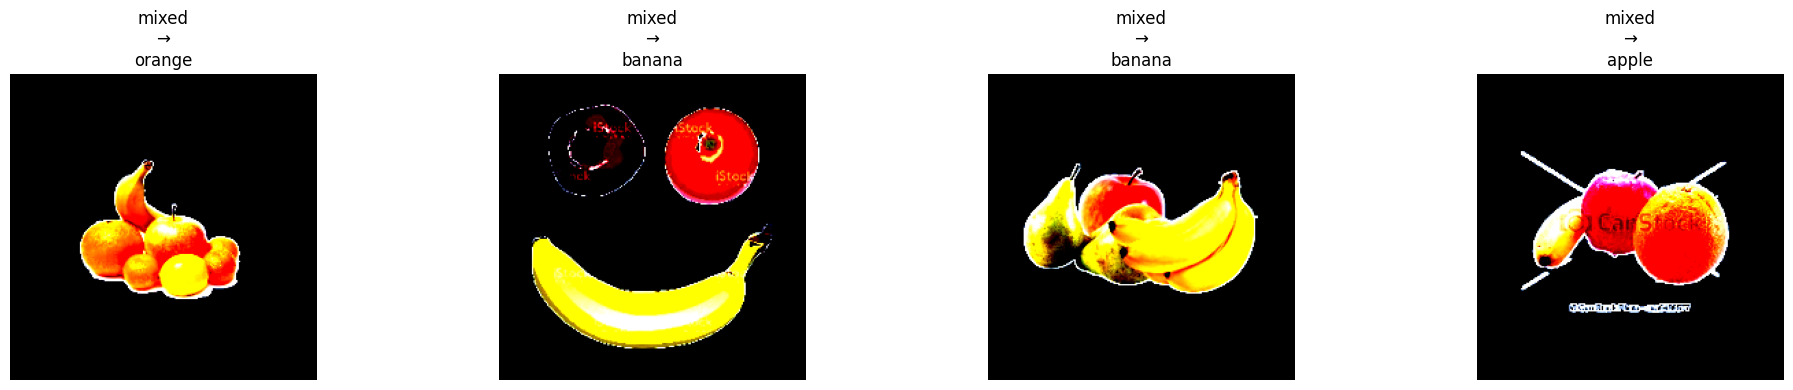


Test Results:
Test Loss: 0.2301
Test Accuracy: 0.9333
Test F1 Score: 0.9124

Test Classification Report:
              precision    recall  f1-score   support

       apple       0.95      1.00      0.97        19
      banana       0.90      1.00      0.95        18
       mixed       1.00      0.20      0.33         5
      orange       0.95      1.00      0.97        18

    accuracy                           0.93        60
   macro avg       0.95      0.80      0.81        60
weighted avg       0.94      0.93      0.91        60



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import random

# 기본 설정
BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4  # ResNet50에 맞는 학습률
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "resnet50"  # ResNet50 사용
PREPROCESS_DIR = 'data/preprocess_data'
PATIENCE = 5
SEED = 42

def seed_everything(seed):
    """재현성을 위한 시드 고정 함수"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        self.root_dir = os.path.join(root_dir, split)
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # 클래스 및 이미지 경로 수집
        for idx, class_name in enumerate(sorted(os.listdir(self.root_dir))):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in sorted(os.listdir(class_dir)):  # 파일 순서 정렬
                    if img_name.endswith('.jpg'):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        # 이미지 크기를 224x224로 맞춤
        image = image.resize((224, 224), Image.BILINEAR)
        image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
        # ResNet의 정규화 적용
        image = self.normalize(image)
        label = self.labels[idx]
        return image, label

    def normalize(self, image):
        """ResNet 표준 정규화"""
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        return (image - mean) / std

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc='Training')
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """혼동 행렬을 시각화."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_loss = total_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, val_acc, val_f1, all_preds, all_labels

def test(model, test_loader, criterion, device, idx_to_class):
    """테스트 데이터에 대한 최종 평가"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    misclassified_images = []
    misclassified_true = []
    misclassified_pred = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)

            # 오분류된 이미지 수집
            misclassified_mask = preds != labels
            if misclassified_mask.any():
                misclassified_images.extend(images[misclassified_mask])
                misclassified_true.extend(labels[misclassified_mask].cpu().numpy())
                misclassified_pred.extend(preds[misclassified_mask].cpu().numpy())

            preds = preds.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader)
    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    # 분류 리포트 생성
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
    report = classification_report(all_labels, all_preds, target_names=class_names)

    # 혼동 행렬 생성 및 시각화
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names, title='Test Confusion Matrix')

    # 오분류된 이미지 시각화
    plot_misclassified_images(
        misclassified_images,
        misclassified_true,
        misclassified_pred,
        class_names
    )

    return test_loss, test_acc, test_f1, report

def main():
    # 시드 고정
    seed_everything(SEED)
    print(f"Using device: {DEVICE}")

    # ResNet50 모델 로드
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(os.listdir(os.path.join(PREPROCESS_DIR, 'train'))))
    model = model.to(DEVICE)

    # 데이터셋 및 데이터로더 생성
    train_dataset = CustomImageDataset(PREPROCESS_DIR, split='train')
    val_dataset = CustomImageDataset(PREPROCESS_DIR, split='val')
    test_dataset = CustomImageDataset(PREPROCESS_DIR, split='test')

    # Worker 초기화 함수 정의
    def worker_init_fn(worker_id):
        worker_seed = SEED + worker_id
        random.seed(worker_seed)
        np.random.seed(worker_seed)
        torch.manual_seed(worker_seed)

    # DataLoader 생성
    generator = torch.Generator()
    generator.manual_seed(SEED)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        worker_init_fn=worker_init_fn,
        generator=generator
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        worker_init_fn=worker_init_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        worker_init_fn=worker_init_fn
    )

    # Loss function과 optimizer 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=3,
        verbose=True
    )

    # Early stopping 초기화
    early_stopping = EarlyStopping(patience=PATIENCE, path='best_model.pth')

    # 클래스 이름 매핑
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

    # 학습 루프
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # 학습
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)

        # 검증
        val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(model, val_loader, criterion, DEVICE)

        # Learning rate 업데이트
        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping 체크
        early_stopping(val_loss, model, optimizer, epoch, val_acc)

        # 현재 에폭의 혼동 행렬 생성 및 저장
        class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
        cm = confusion_matrix(val_labels, val_preds)
        plot_confusion_matrix(cm, class_names, title=f'Validation Confusion Matrix Epoch {epoch+1}')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 최고 성능 모델 로드
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # 테스트 데이터로 최종 평가
    test_loss, test_acc, test_f1, test_report = test(model, test_loader, criterion, DEVICE, idx_to_class)
    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("\nTest Classification Report:")
    print(test_report)

if __name__ == "__main__":
    main()

Using device: cuda

Epoch 1/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.72it/s]


Train Loss: 0.3715, Train Acc: 0.8935
Val Loss: 0.2271, Val Acc: 0.8776, Val F1: 0.8836
Current LR: 0.000100

Epoch 2/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]


Train Loss: 0.0389, Train Acc: 0.9860
Val Loss: 0.2207, Val Acc: 0.8980, Val F1: 0.9021
Current LR: 0.000100

Epoch 3/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.95it/s]


Train Loss: 0.0221, Train Acc: 0.9925
Val Loss: 0.1286, Val Acc: 0.8980, Val F1: 0.9002
Current LR: 0.000100

Epoch 4/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]


Train Loss: 0.0221, Train Acc: 0.9903
Val Loss: 0.1484, Val Acc: 0.9184, Val F1: 0.9167
Current LR: 0.000100
EarlyStopping counter: 1 out of 5

Epoch 5/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.54it/s]


Train Loss: 0.0060, Train Acc: 0.9978
Val Loss: 0.0593, Val Acc: 0.9592, Val F1: 0.9600
Current LR: 0.000100

Epoch 6/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.21it/s]


Train Loss: 0.0085, Train Acc: 0.9962
Val Loss: 0.0799, Val Acc: 0.9592, Val F1: 0.9592
Current LR: 0.000100
EarlyStopping counter: 1 out of 5

Epoch 7/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


Train Loss: 0.0271, Train Acc: 0.9930
Val Loss: 0.1786, Val Acc: 0.9388, Val F1: 0.9386
Current LR: 0.000100
EarlyStopping counter: 2 out of 5

Epoch 8/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.64it/s]


Train Loss: 0.0278, Train Acc: 0.9887
Val Loss: 0.1351, Val Acc: 0.9388, Val F1: 0.9394
Current LR: 0.000100
EarlyStopping counter: 3 out of 5

Epoch 9/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.26it/s]


Train Loss: 0.0116, Train Acc: 0.9973
Val Loss: 0.0379, Val Acc: 0.9796, Val F1: 0.9796
Current LR: 0.000100

Epoch 10/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.57it/s]


Train Loss: 0.0080, Train Acc: 0.9962
Val Loss: 0.0085, Val Acc: 1.0000, Val F1: 1.0000
Current LR: 0.000100

Epoch 11/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]


Train Loss: 0.0073, Train Acc: 0.9978
Val Loss: 0.0371, Val Acc: 1.0000, Val F1: 1.0000
Current LR: 0.000100
EarlyStopping counter: 1 out of 5

Epoch 12/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.41it/s]


Train Loss: 0.0032, Train Acc: 0.9984
Val Loss: 0.0537, Val Acc: 0.9592, Val F1: 0.9581
Current LR: 0.000100
EarlyStopping counter: 2 out of 5

Epoch 13/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.19it/s]


Train Loss: 0.0025, Train Acc: 0.9995
Val Loss: 0.0163, Val Acc: 1.0000, Val F1: 1.0000
Current LR: 0.000100
EarlyStopping counter: 3 out of 5

Epoch 14/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]


Train Loss: 0.0047, Train Acc: 0.9978
Val Loss: 0.0948, Val Acc: 0.9592, Val F1: 0.9592
Current LR: 0.000010
EarlyStopping counter: 4 out of 5

Epoch 15/30


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.30it/s]


Train Loss: 0.0011, Train Acc: 1.0000
Val Loss: 0.1028, Val Acc: 0.9796, Val F1: 0.9804
Current LR: 0.000010
EarlyStopping counter: 5 out of 5


<ipython-input-12-e9c1bd3bc037>:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Early stopping triggered


Testing: 100%|██████████| 4/4 [00:00<00:00, 11.20it/s]



Test Results:
Test Loss: 0.4458
Test Accuracy: 0.9000
Test F1 Score: 0.8930

Test Classification Report:
              precision    recall  f1-score   support

       apple       0.94      0.89      0.92        19
      banana       0.85      0.94      0.89        18
       mixed       0.67      0.40      0.50         5
      orange       0.95      1.00      0.97        18

    accuracy                           0.90        60
   macro avg       0.85      0.81      0.82        60
weighted avg       0.89      0.90      0.89        60



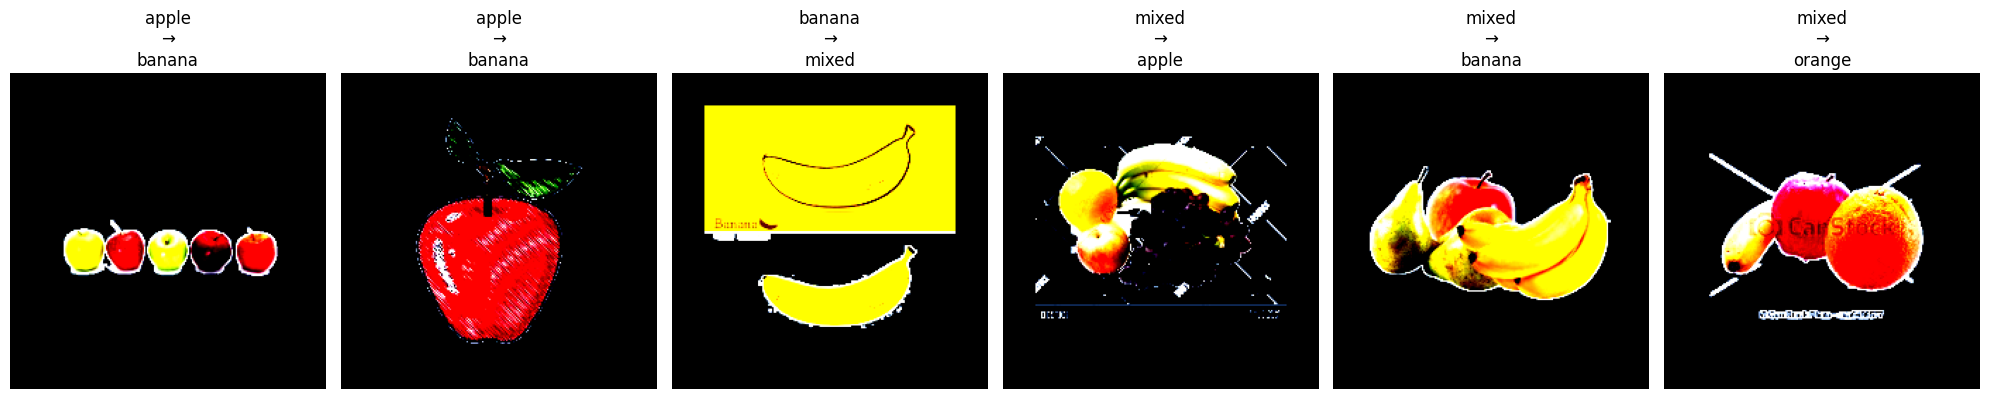

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import random

# 기본 설정
BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4  # EfficientNet 학습률
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "efficientnet_b0"
PREPROCESS_DIR = 'data/preprocess_data'
PATIENCE = 5
SEED = 42

def seed_everything(seed):
    """재현성을 위한 시드 고정 함수"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        self.root_dir = os.path.join(root_dir, split)
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # 클래스 및 이미지 경로 수집
        for idx, class_name in enumerate(sorted(os.listdir(self.root_dir))):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in sorted(os.listdir(class_dir)):
                    if img_name.endswith('.jpg'):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = image.resize((224, 224), Image.BILINEAR)
        image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
        # ImageNet 정규화 적용
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        image = (image - mean) / std
        label = self.labels[idx]
        return image, label

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc='Training')
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """혼동 행렬 시각화"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()

class EarlyStopping:
    """Early stopping 구현"""
    def __init__(self, patience=7, min_delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, optimizer, epoch, val_acc):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer, epoch, val_acc)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer, epoch, val_acc)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch, val_acc):
        """모델 체크포인트 저장"""
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }, self.path)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_loss = total_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, val_acc, val_f1, all_preds, all_labels

def plot_misclassified_images(images, true_labels, pred_labels, class_names, num_images=10):
    """오분류된 이미지 시각화"""
    n = min(len(images), num_images)
    if n == 0:
        print("No misclassified images found.")
        return

    fig = plt.figure(figsize=(20, 4))
    for idx in range(n):
        ax = plt.subplot(1, n, idx + 1)
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'{class_names[true_labels[idx]]}\n→\n{class_names[pred_labels[idx]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('misclassified_examples.png')
    plt.show

def test(model, test_loader, criterion, device, idx_to_class):
    """테스트 데이터에 대한 최종 평가"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    misclassified_images = []
    misclassified_true = []
    misclassified_pred = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)

            # 오분류된 이미지 수집
            misclassified_mask = preds != labels
            if misclassified_mask.any():
                misclassified_images.extend(images[misclassified_mask])
                misclassified_true.extend(labels[misclassified_mask].cpu().numpy())
                misclassified_pred.extend(preds[misclassified_mask].cpu().numpy())

            preds = preds.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader)
    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    # 분류 리포트 생성
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
    report = classification_report(all_labels, all_preds, target_names=class_names)

    # 혼동 행렬 생성 및 시각화
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names, title='Test Confusion Matrix')

    # 오분류된 이미지 시각화
    plot_misclassified_images(
        misclassified_images,
        misclassified_true,
        misclassified_pred,
        class_names
    )

    return test_loss, test_acc, test_f1, report

def main():
    # 시드 고정
    seed_everything(SEED)
    print(f"Using device: {DEVICE}")

    # EfficientNet 모델 로드
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(os.listdir(os.path.join(PREPROCESS_DIR, 'train'))))
    model = model.to(DEVICE)

    # 데이터셋 및 데이터로더 생성
    train_dataset = CustomImageDataset(PREPROCESS_DIR, split='train')
    val_dataset = CustomImageDataset(PREPROCESS_DIR, split='val')
    test_dataset = CustomImageDataset(PREPROCESS_DIR, split='test')

    # Worker 초기화 함수 정의
    def worker_init_fn(worker_id):
        worker_seed = SEED + worker_id
        random.seed(worker_seed)
        np.random.seed(worker_seed)
        torch.manual_seed(worker_seed)

    # DataLoader 생성
    generator = torch.Generator()
    generator.manual_seed(SEED)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        worker_init_fn=worker_init_fn,
        generator=generator
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        worker_init_fn=worker_init_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        worker_init_fn=worker_init_fn
    )

    # Loss function과 optimizer 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=3,
        verbose=True
    )

    # Early stopping 초기화
    early_stopping = EarlyStopping(patience=PATIENCE, path='best_model.pth')

    # 클래스 이름 매핑
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

    # 학습 루프
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # 학습
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)

        # 검증
        val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(model, val_loader, criterion, DEVICE)

        # Learning rate 업데이트
        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping 체크
        early_stopping(val_loss, model, optimizer, epoch, val_acc)

        # 현재 에폭의 혼동 행렬 생성 및 저장
        class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
        cm = confusion_matrix(val_labels, val_preds)
        plot_confusion_matrix(cm, class_names, title=f'Validation Confusion Matrix Epoch {epoch+1}')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 최고 성능 모델 로드
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # 테스트 데이터로 최종 평가
    test_loss, test_acc, test_f1, test_report = test(model, test_loader, criterion, DEVICE, idx_to_class)
    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("\nTest Classification Report:")
    print(test_report)

if __name__ == "__main__":
    main()